# Figure panels

In [7]:
import pickle

import numpy as onp

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import colorcet  as cc  # used for maximally distinct categorical colors

from dtd.data import load_wiltschko22_data
from dtd.model3d import DirichletTuckerDecomp
from dtd.viz import draw_drug_class_boxes, set_syllable_cluster_ticks, set_time_within_session_ticks

In [10]:
mpl.rcParams['font.size'] = 10
mpl.rcParams['figure.dpi'] = 600

# Let exported fonts be editable
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mm_to_in = 1/25.4

In [11]:
DATASET_DIR = "/home/groups/swl1/eyz/data/moseq-drugs/"

In [12]:
DATASET_DIR = "/home/groups/swl1/eyz/data/moseq-drugs/"

# Load the binned syllable usage data and sum across bins.
# This is equivalent to loading the raw syllable sequences and summing across the full session.
filepath = DATASET_DIR + "syllable_binned_1min.npz"
X, batch_axes, event_axes, metadata = load_wiltschko22_data(filepath)

# Format labels for annotating plots later
syllable_cluster_names = metadata['syllable']['cluster_names']
frames_per_bin = metadata['frames_per_bin']
frames_per_sec = metadata['frames_per_sec']

# Modify long-form session drug class to print over two lines, for readability
session_drug_class_twoline = [
    name if name[:4] != 'anti' else 'anti-\n' + name[4:]
    for name in list(metadata['session']['drug_class'])
]

# Combine drug-dose labels
drug_names = metadata['session']['drug_names']
drug_dose_labels = [
    f'{drug}-{dose}' for drug, dose in zip(metadata['session']['drug_names'], metadata['session']['drug_doses'])
]

## Raw data: Movement PCs and Syllables

We will choose to demonstrate data for the most median CTRL session.

- **[TODO]** Identify the most median CTRL session for now, we choose a CTRL session at random.
- **[TODO]** Identify time snippet to show, and whether 30 s as in original paper or 1 min as in binned data.

In [31]:
# Load dimensionality-reduced movement data

# Loaded data is an OrderedDict organized by individual sessions.
filepath = DATASET_DIR + "original/dataset.pkl"
with open(filepath, 'rb') as f:
    original_data = pickle.load(f, encoding='latin1')

In [32]:
# Selected CTRL session to display
# Session index AFTER removing outlier session 217 in original dataset
# See "A01-Preprocess-original-dataset.ipynb" for more details.
selected_session_id = 410
selected_session_name = list(original_data.keys())[selected_session_id+1]

# Randomly selected 30 s frame
start_frame = 500
duration = 30 * 30  # 30 s * 30 fps
selected_time_slice = slice(start_frame, start_frame+duration)

In [12]:
# shape (36_000, 10)
selected_pcs = original_data[selected_session_name]['data']

**[TODO]** Remake mouse pose PCs plot to be aligned with syllable data

In [15]:
onp.nanmax(selected_pcs)

np.float64(575.078570505544)

#### One hot encoding of syllable sequence

In [9]:
DATASET_DIR = "/home/groups/swl1/eyz/data/moseq-drugs/"

filepath = DATASET_DIR + "syllable_sequence_data.npz"
with onp.load(filepath) as f:
    session_syllables = f['session_syllables']
    # session_drug_name = f['session_drug_name']
    # session_drug_class = f['session_drug_class']
    # session_drug_dose_0to6 = f['session_drug_dose_0to6']
    perm_syllable_id = f['perm_syllable_id']
    perm_syllable_cluster = f['perm_syllable_cluster']
session_syllables.shape

(500, 36000)

##### 30 s window

In [20]:
selected_syllables = session_syllables[selected_session_id, selected_time_slice]
selected_syllables.shape

(900,)

In [41]:
# Convert syllable sequence to one hot encoding; discard NaNs
selected_syllables_onehot = onp.eye(91)[selected_syllables][:,:90]

# Permute syllables so that they match syllable clusters
selected_syllables_onehot = selected_syllables_onehot[:, perm_syllable_id]

print(f"{selected_syllables_onehot.shape=}")


selected_syllables_onehot.shape=(900, 90)


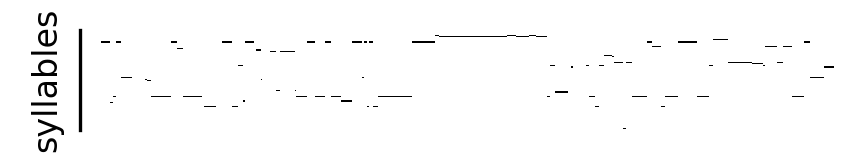

In [76]:
plt.figure(figsize=(80*mm_to_in, 11*mm_to_in))

ax = plt.gca()
ax.imshow(
    selected_syllables_onehot[:,:-1].T,
    aspect='auto', interpolation='none',
    cmap='binary', clim=(0,1), )

# set_syllable_cluster_ticks(perm_syllable_cluster, grid=False, label=False, axis='y')
ax.set_yticks([])
ax.tick_params(labelleft=False)
ax.set_ylabel('syllables', fontsize=8)

ax.tick_params(bottom=False, labelbottom=False)
sns.despine(bottom=True, offset=5)


##### Full session

In [11]:
selected_syllables = session_syllables[selected_session_id]

selected_syllables_onehot = onp.eye(91)[selected_syllables][:,:90]

# Permute syllables so that they match syllable clusters
selected_syllables_onehot = selected_syllables_onehot[:, perm_syllable_id]

print(f"{selected_syllables_onehot.shape=}")


selected_syllables_onehot.shape=(36000, 90)


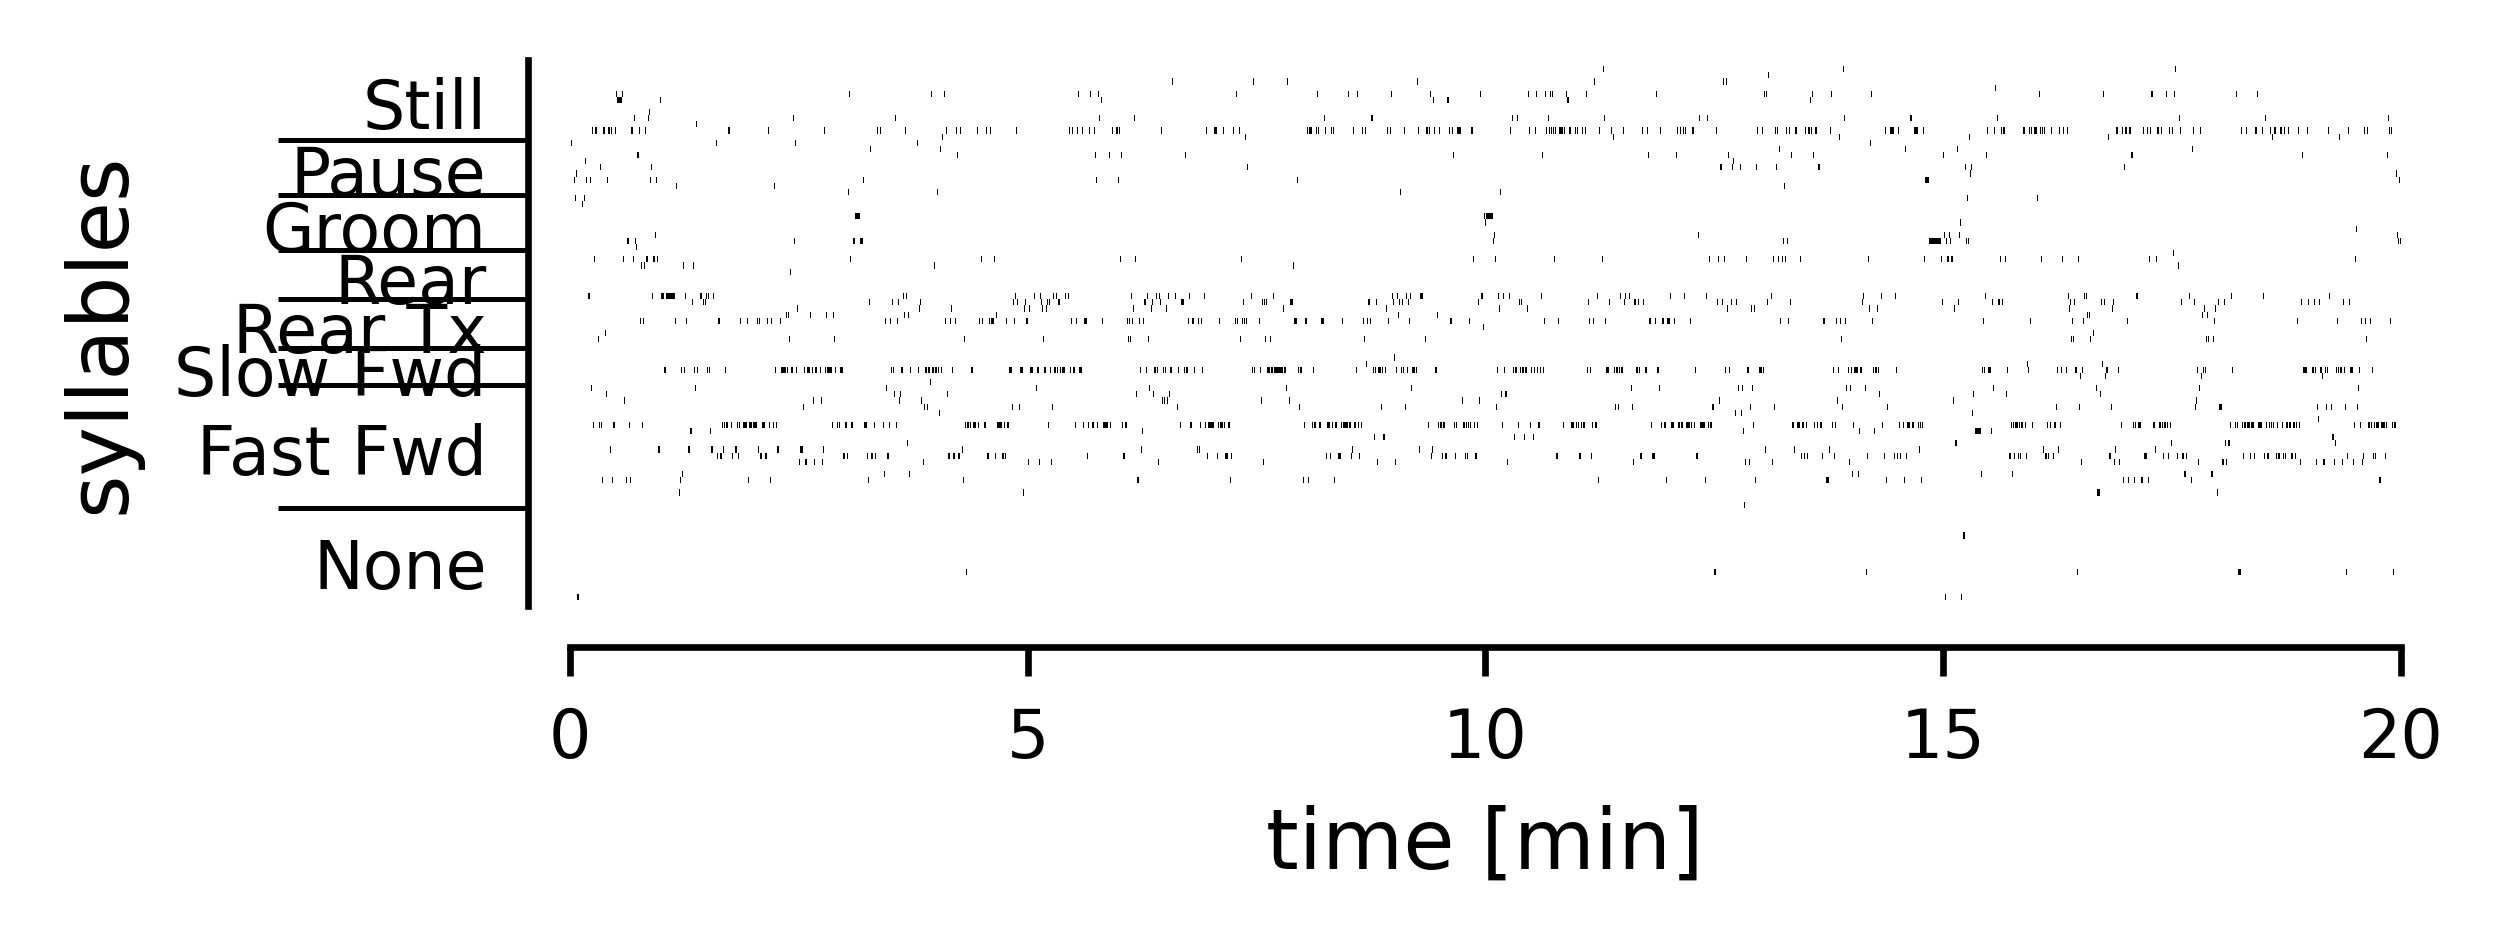

In [29]:
plt.figure(figsize=(100*mm_to_in, 30*mm_to_in))

ax = plt.gca()
ax.imshow(
    selected_syllables_onehot[:,:-1].T,
    aspect='auto', interpolation='none',
    cmap='binary', clim=(0,1), )

# set_syllable_cluster_ticks(perm_syllable_cluster, grid=False, label=False, axis='y')
# ax.set_yticks([])
# ax.tick_params(labelleft=False)
# y-axis: syllable ids, shared with left subplot
set_syllable_cluster_ticks(
    perm_syllable_cluster,
    ticklabel_kwargs={'fontsize': 8},
    axis='y', grid=False, ax=ax
)
ax.set_ylabel('syllables', fontsize=10)

ax.tick_params(axis='y', which='minor', length=30)

# ax.tick_params(bottom=False, labelbottom=False)

set_time_within_session_ticks(
    36_000, 1, 30, tick_period=5, tick_units='min', ax=ax,
)
ax.tick_params(labelsize=8,)

ax.set_xlabel('time [min]', fontsize=10)


sns.despine(offset=5)




#### Session vs. time by syllable
Show examples of the top 5 most used syllables. Or top, median, lowest used syllable.

In [42]:
selected_syllable_ids = [0,1,2]

selected_syllables_onehot = onp.stack(
    [session_syllables == syllable_id for syllable_id in selected_syllable_ids], axis=-1
)

selected_syllables_onehot.shape

(500, 36000, 3)

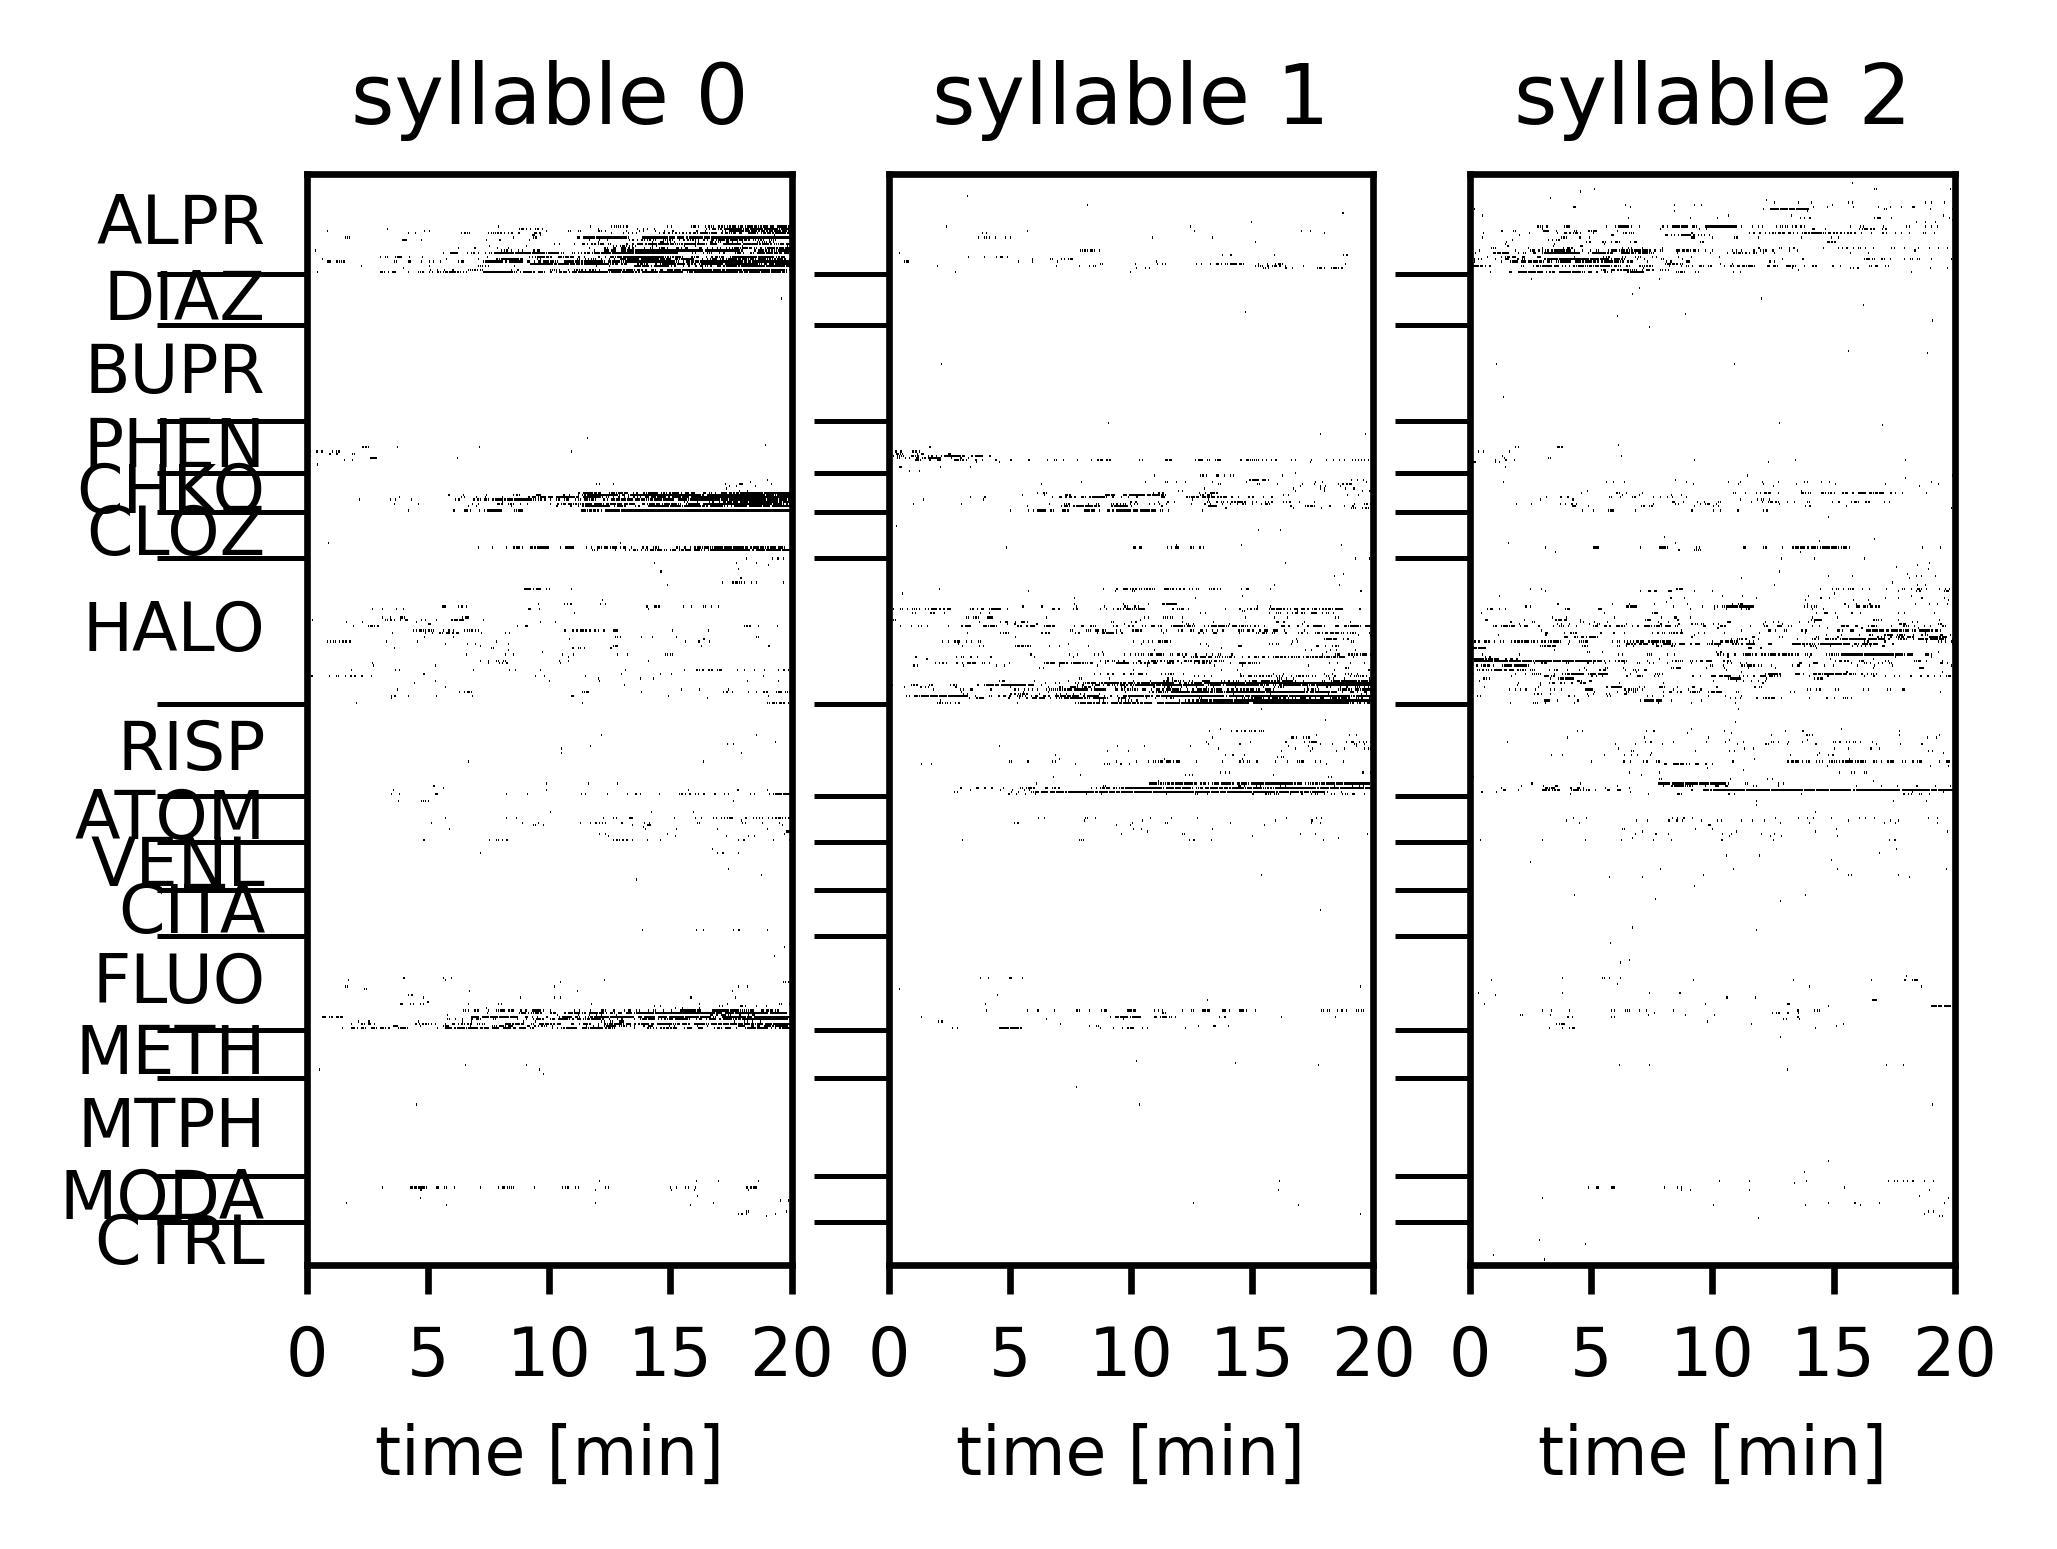

In [60]:
fig, axs = plt.subplots(nrows=1, ncols=len(selected_syllable_ids), figsize=(90*mm_to_in, 60*mm_to_in))

for i, (syllable_id, ax) in enumerate(zip(selected_syllable_ids, axs)):
    ax.imshow(
        selected_syllables_onehot[...,i], aspect='auto', interpolation='none',
        cmap='binary', clim=(0,1), )
    ax.set_title(f"syllable {syllable_id}", fontsize=10)

    set_syllable_cluster_ticks(drug_names, label=(i==0), grid=False, axis='y', ax=ax)

    set_time_within_session_ticks(
        36_000, 1, 30, tick_period=5, tick_units='min', ax=ax,
    )
    ax.set_xlabel('time [min]', fontsize=8)

    ax.tick_params(labelsize=8)


## Syllable bins

In [59]:
# Load the binned syllable usage data and sum across bins.
# This is equivalent to loading the raw syllable sequences and summing across the full session.
filepath = DATASET_DIR + "syllable_binned_1min.npz"
X, batch_axes, event_axes, metadata = load_wiltschko22_data(filepath)

print(f"{X.shape=}")

X.shape=(500, 20, 90)


In [109]:
selected_bin_data = onp.asarray(X[selected_session_id], dtype=float)
selected_bin_data /= selected_bin_data.sum(axis=-1, keepdims=True)

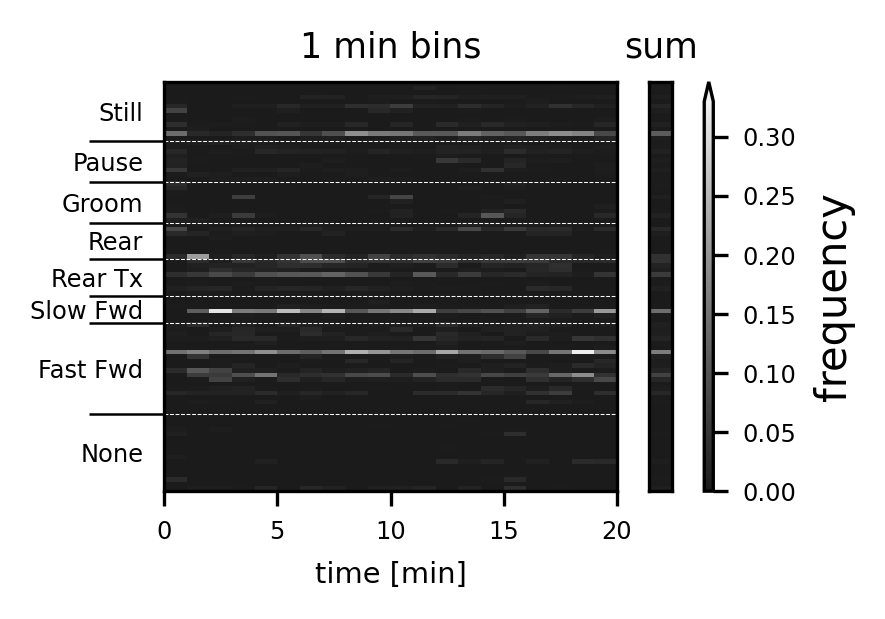

In [133]:
raw_cmap = cc.cm['dimgray']

fig, (ax_bin, ax_sum, cax) = plt.subplots(
    nrows=1, ncols=3, width_ratios=[10, 0.5, 0.2],
    figsize=(60*mm_to_in, 45*mm_to_in)
)

vmax = 0.33
imshow_kwargs = dict(
    cmap=raw_cmap, vmin=0, vmax=vmax, interpolation='none', aspect='auto'
)
# ----------------------------------------------
# Show binned syllable data
# ----------------------------------------------
ax = ax_bin
im = ax.imshow(selected_bin_data.T, **imshow_kwargs)

set_syllable_cluster_ticks(
    perm_syllable_cluster,
    ticklabel_kwargs={'fontsize': 'xx-small'},
    grid=True, grid_kwargs={'lw':0.25, 'ls':'--', 'c': 'white'},
    ax=ax,
    axis='y'
)

set_time_within_session_ticks(
    20, metadata['frames_per_bin'], metadata['frames_per_sec'], tick_period=5, tick_units='min', ax=ax,
)
ax.set_xlabel('time [min]', fontsize='x-small')

ax.tick_params(labelsize='xx-small', )

ax.set_title('1 min bins', fontsize='small')

# ----------------------------------------------
# Show summed syllable data
# ----------------------------------------------
ax = ax_sum
selected_sum_data = selected_bin_data.sum(axis=0) / selected_bin_data.sum()

ax.imshow(onp.atleast_2d(selected_sum_data).T, **imshow_kwargs)

ax.set_xticks([])

# y-axis: syllable ids, shared with left subplot
set_syllable_cluster_ticks(ax, axis='y', ax=ax, label=False)

ax.set_title('sum', fontsize='small')

# ----------------------------------------------
# Show colorbar
# ----------------------------------------------
plt.colorbar(im, cax=cax, extend='max', label='frequency')
cax.tick_params(labelsize='xx-small')

## DTD

In [13]:
filepath = DATASET_DIR + "syllable_binned_1min.npz"
X, batch_axes, event_axes, metadata = load_wiltschko22_data(filepath)

In [14]:

from jax import lax, vmap
import jax.numpy as jnp
import jax.random as jr
import numpy as onp

def fit_dtd(key, X, k1, k2, k3, n_inits=10, n_iters=500):
    """Fit DTD model with n random initializations; return model with best log prob."""
    d1, d2, d3 = X.shape
    event_axes = (2,)
    batch_shape = (d1,d2)

    total_counts = int(X.sum(event_axes).ravel()[0])
    dummy_mask = jnp.ones(batch_shape, dtype=bool)  # batch_ndims=2
    model = DirichletTuckerDecomp(total_counts, k1, k2, k3, alpha=1.1)

    def _fit(key, ):
        # Initialize
        init_params = model.sample_params(key, d1, d2, d3, conc=0.5)

        # Fit model to held-in data
        params, lps = model.fit(X, dummy_mask, init_params, n_iters)

        return params, lps[-1]

    all_params, all_lps = vmap(_fit)(jr.split(key, n_inits))

    # Use the param with the best log prob
    i_best = jnp.argmax(all_lps)
    params = tuple([param[i_best] for param in all_params])

    return params

key = jr.key(1230)
k1, k2, k3 = 20, 4, 30  # these is the model size suggested by cross-validation
n_iters = 500
n_inits = 10
dtd_params_min = fit_dtd(key, X, k1, k2, k3, n_inits=1, n_iters=500)

  0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
core_tensor, session_factors, temporal_factors, topics = dtd_params_min

Text(0, 0.5, 'topics')

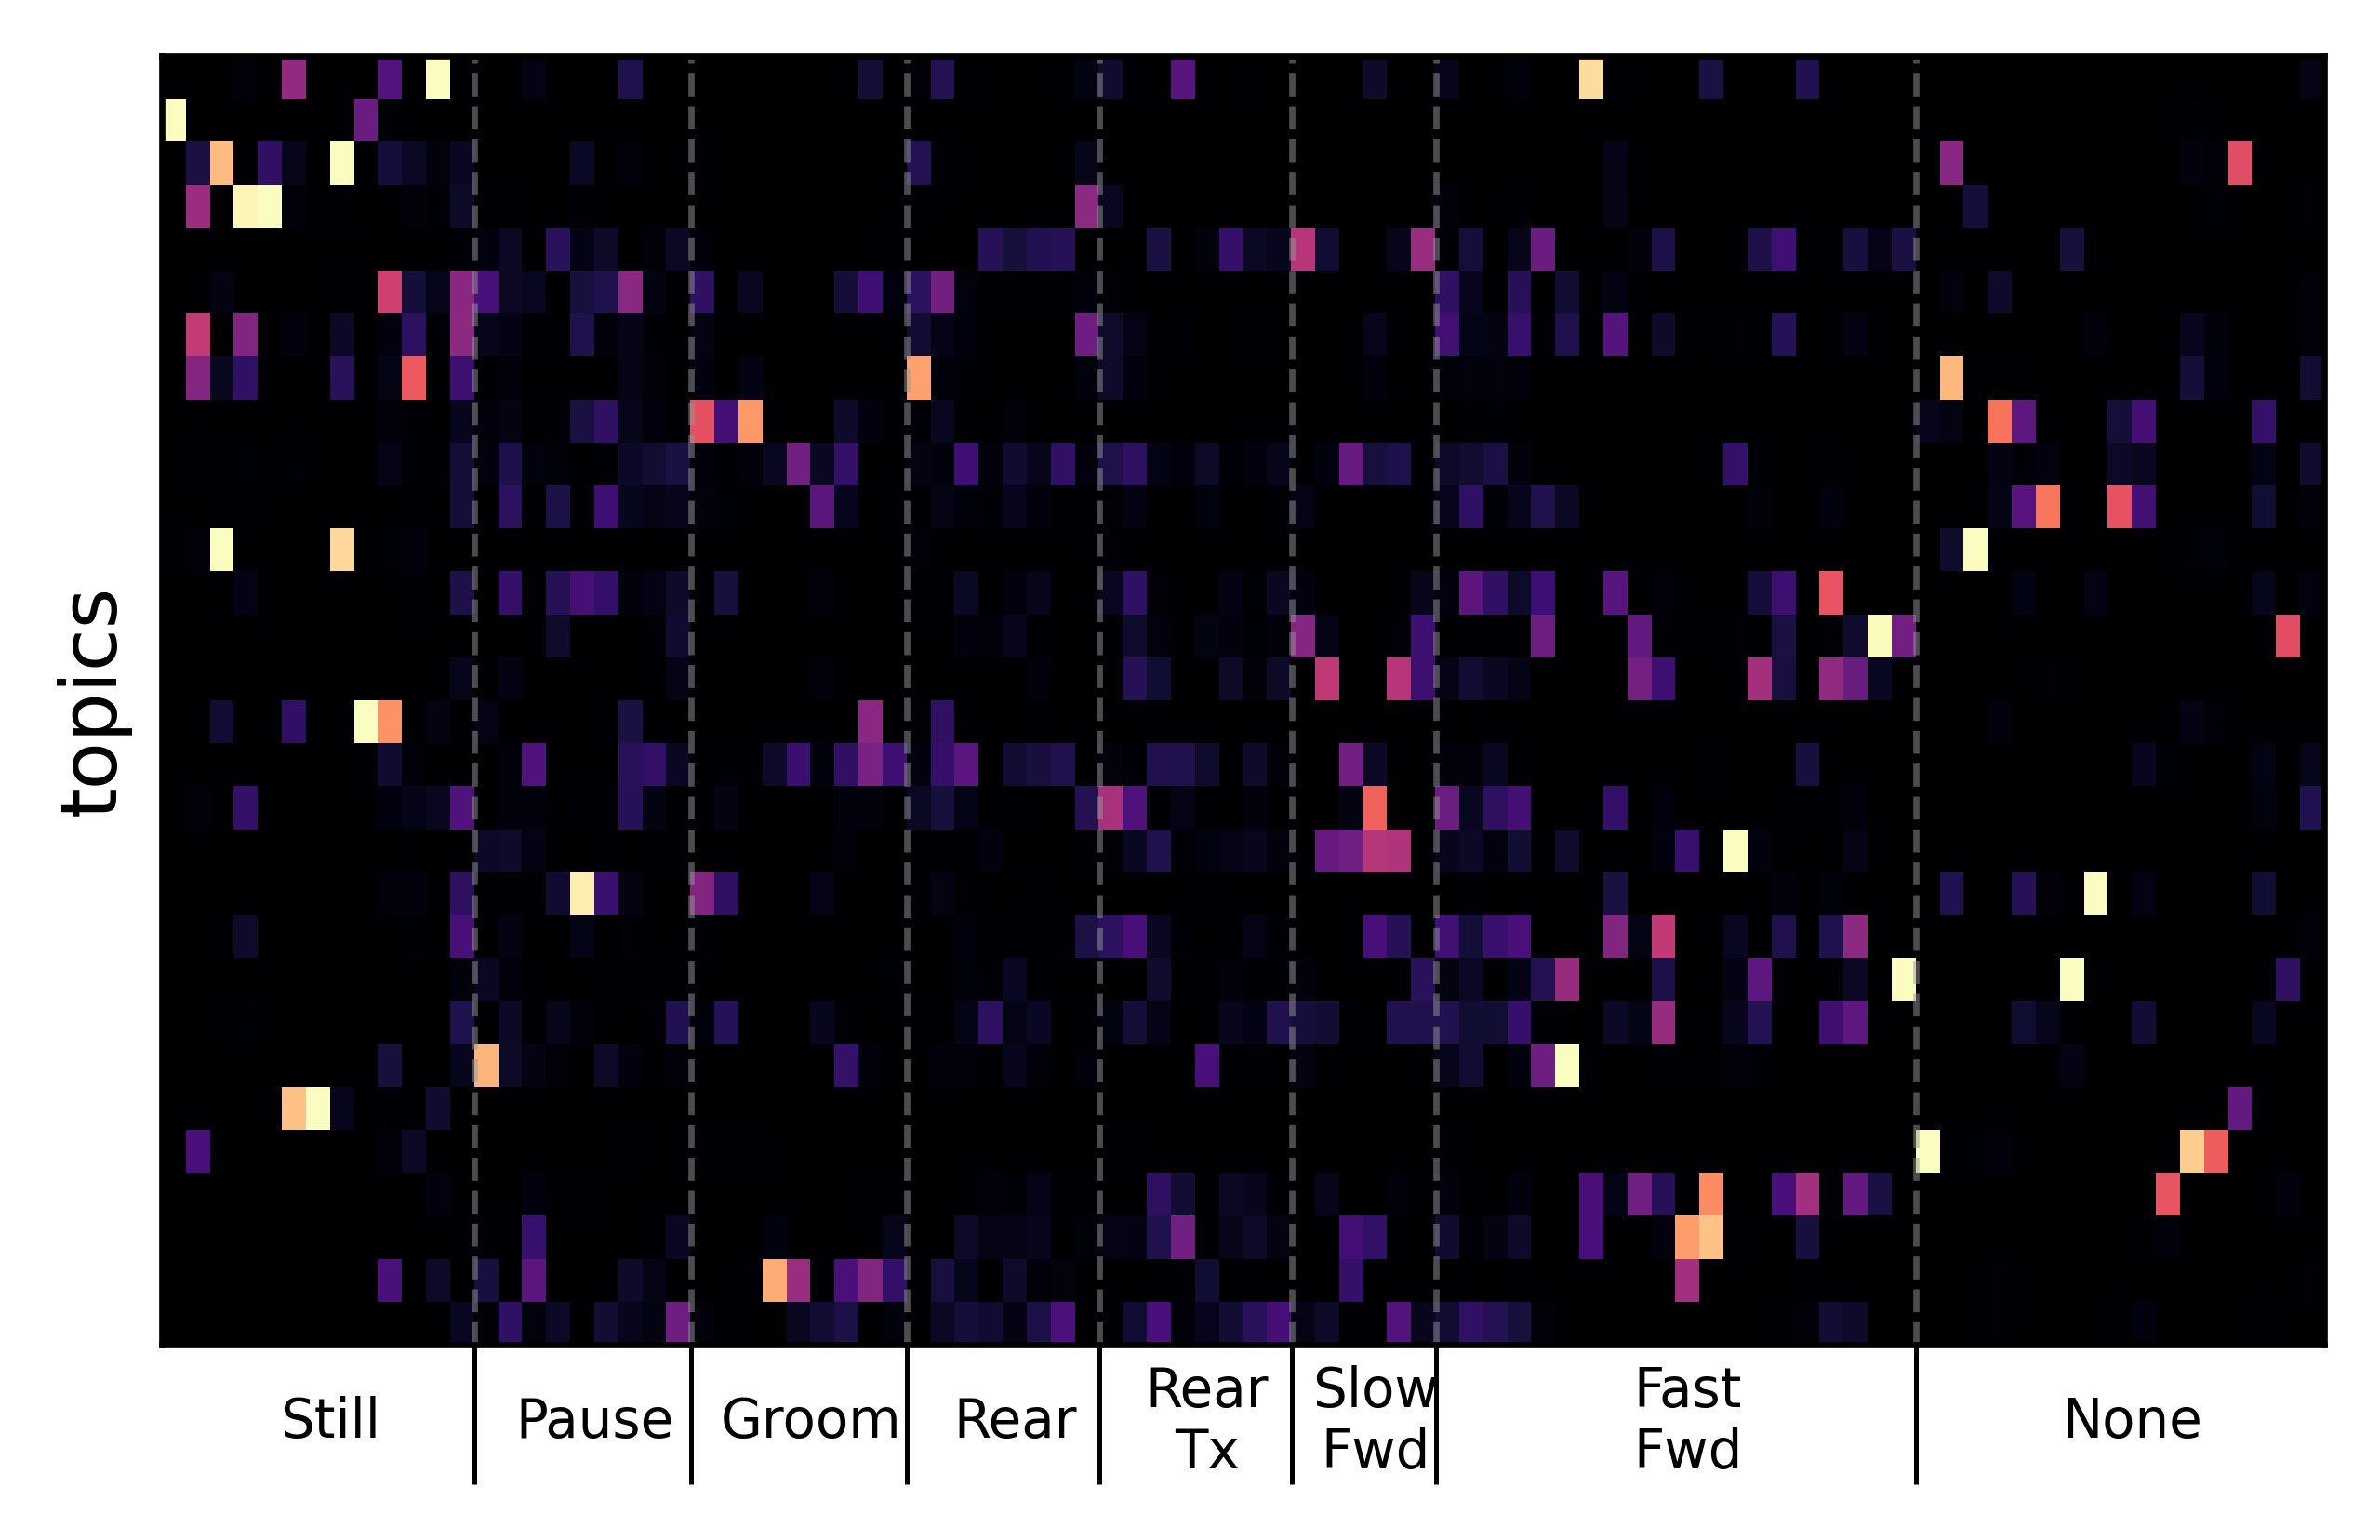

In [24]:

plt.figure(figsize=(5,3))
vmax = onp.percentile(topics, 99.5)


plt.imshow(topics, cmap='magma', vmax=vmax, interpolation='none', aspect='auto')

set_syllable_cluster_ticks(syllable_cluster_names, axis='x')
ax = plt.gca()
ax.tick_params(left=False, labelleft=False)
ax.set_ylabel("topics")

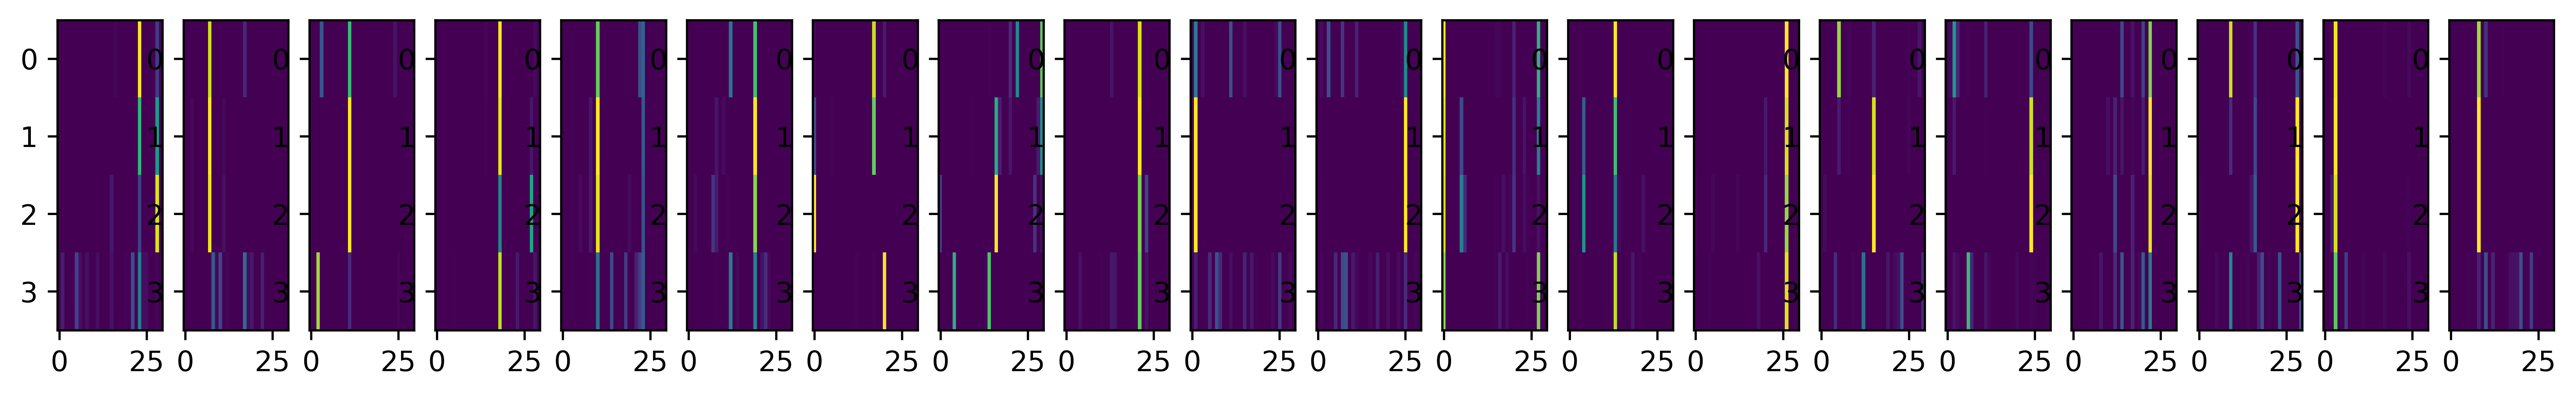

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=len(core_tensor), figsize=(16,2))

for i, ax in enumerate(axs):
    ax.imshow(core_tensor[i], aspect='auto')